In [1]:
from __future__ import division

In [2]:
# Simulates one group of 4 peers

# Max Bandwidth (Mbps)
max_bps = 30
# Min Bandwidth (Mbps)
min_bps = 5

# Number of peers in group
n_peers = 4

# Randomized Maximum Bandwidth per Peer (Mbps)
# (arms per peer)
L = {0: 28, 1: 18, 2:15, 3: 23}
print 'Maximum Bandwidth of Peers'
for k, v in L.iteritems():
    print 'Bandit {}: {}'.format(k, v)
group_L = sum(L.values())

# Peer minimum contribution of policy
# a.k.a., each must allocate at least this amount to be receive
# resources in return.
# "Buy-In"
min_contrib = 7

Maximum Bandwidth of Peers
Bandit 0: 28
Bandit 1: 18
Bandit 2: 15
Bandit 3: 23


In [3]:
# Simulations
simulations = 1

# Variables to Report Progress of Simulations
if simulations == 1:
    prg = 1
else:
    prg = simulations/10

In [4]:
# Stats to Track
avg_cumulative_rewards = None
avg_rewards = None

In [5]:
from datetime import datetime
from collections import defaultdict
import numpy as np
from peer import Peer


# Start ith simulation
for sim in xrange(simulations):
    if sim % prg == 0:
        print sim*100/simulations, '%', datetime.now()

    # Create peers
    # Initialize all peers to expect all other peers
    # can at least provide the minimum contribution.
    peers = [
        Peer(
            pid,
            bps,
            min_contrib,
            {p: (min_contrib, 1) for p in L.iterkeys() if p is not pid}
        )
        for pid, bps in L.iteritems()
    ]
    assert(len(peers) == n_peers)
    for peer in peers:
        assert(peer.name not in peer.est_alloc)
        assert(len(peer.est_alloc) == (n_peers - 1))

    # Initialize States
    # cold-start
    S = {pid: {} for pid in L.iterkeys()}

    # Rounds
    T = 200

    # Stats
    rewards = np.zeros((n_peers, T))
    cumulative_rewards = np.zeros((n_peers, T))

    # Run one simulation
    for t in xrange(T):
        # new states for round t
        S_new = defaultdict(lambda: {})
        # arms
        arms = {}
        # features
        features = {}
        for peer in peers:
            #print t, S
            if peer.name in S:
                s = S[peer.name]
            else:
                # If peer doesn't have any states,
                # it means they aren't receiveing any resources.
                s = {}

            arm, res_alloc, feature = peer.choose_res_alloc(s, min_contrib)
            assert(arm in L.keys() or arm == 'no')

            # Map the resource allocations as the new states.
            for peer_k, r in res_alloc.iteritems():
                S_new[peer_k][peer.name] = r

            # Save these values for updating
            arms[peer.name] = arm
            features[peer.name] = feature

        # Rewards
        # We create an array for it because we keep a rewards
        # history as a matrix.
        r = []
        # For each peer...
        for peer in peers:
            # ... it's reward is the sum of allocation from peers.
            r.append(sum(S_new[peer.name].values()))
        rewards[:, t] = r
        assert(int(sum(r)) <= group_L)

        if t == 0:
            cumulative_rewards[:, t] = r
        else:
            cumulative_rewards[:, t] = cumulative_rewards[:, t-1] + r

        for i, peer in enumerate(peers):
            peer.update(arms[peer.name], features[peer.name], r[i])

        S = S_new

    if sim == 0:
        avg_cumulative_rewards = cumulative_rewards
        avg_rewards = rewards
    else:
        avg_cumulative_rewards = np.dstack((avg_cumulative_rewards, cumulative_rewards))
        avg_cumulative_rewards = np.average(avg_cumulative_rewards, axis=2, weights=[float(sim-1)/sim, 1./sim])

        avg_rewards = np.dstack((avg_rewards, rewards))
        avg_rewards = np.average(avg_rewards, axis=2, weights=[float(sim-1)/sim, 1./sim])

0.0 % 2016-02-28 20:16:25.347355


In [6]:
from pprint import PrettyPrinter


pp = PrettyPrinter()
# Simulates one group of 4 peers
print 'Steady-State Resource Allocation'
pp.pprint(S)

Steady-State Resource Allocation
defaultdict(<function <lambda> at 0x104a1c230>, {0: {1: 18.0}, 1: {0: 28.0, 3: 9.23547999963645}, 2: {3: 13.76452000036355}, 3: {2: 15.0}})


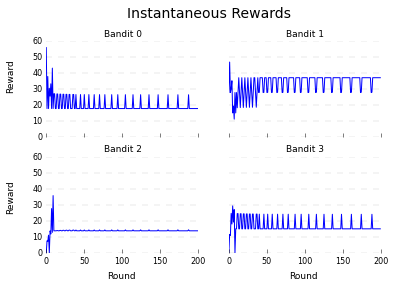

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


# Cumulative Rewards Plot
cr_plt, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True, sharey=True) # Cumulative rewards plot
cr_ax = [ax1, ax2, ax3, ax4]

# Make room for the title then add it
cr_plt.subplots_adjust(top=.86)
cr_plt.suptitle('Cumulative Rewards', fontsize=14, ha='center')

# Manually set axes labels
cr_plt.text(0.3, 0.035, 'Round', fontsize=9, ha='center')
cr_plt.text(0.72, 0.035, 'Round', fontsize=9, ha='center')
cr_plt.text(0.045, 0.35, 'Reward', fontsize=9, ha='center', rotation='vertical')
cr_plt.text(0.045, 0.77, 'Reward', fontsize=9, ha='center', rotation='vertical')

# Cumulative Rewards Plot
for i, ax in enumerate(cr_ax):
    ax.plot(range(T), avg_cumulative_rewards[i, :])
    
    # Remove the plot frame lines. They are unnecessary chartjunk.
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    # Provide tick lines across the plot to help your viewers trace along    
    # the axis ticks. Make sure that the lines are light and small so they    
    # don't obscure the primary data lines.    
    for y in range(0, 601, 100):    
        ax.plot(range(T), [y] * len(range(T)), "--", lw=0.5, color="black", alpha=0.3)
        
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
    ax.tick_params(axis="both", which="both", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on", labelsize=8) 
    ax.set_title('Bandit {}'.format(i), fontsize=9)

# Instantaneous Rewards Plot
r_plt, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True, sharey=True) # Cumulative rewards plot
r_ax = [ax1, ax2, ax3, ax4]

# Make room for the title then add it
r_plt.subplots_adjust(top=.86)
r_plt.suptitle('Instantaneous Rewards', fontsize=14, ha='center')
# Manually set axes labels
r_plt.text(0.3, 0.035, 'Round', fontsize=9, ha='center')
r_plt.text(0.72, 0.035, 'Round', fontsize=9, ha='center')
r_plt.text(0.045, 0.35, 'Reward', fontsize=9, ha='center', rotation='vertical')
r_plt.text(0.045, 0.77, 'Reward', fontsize=9, ha='center', rotation='vertical')

for i, ax in enumerate(r_ax):
    ax.plot(range(T), avg_rewards[i, :])
    
    # Remove the plot frame lines. They are unnecessary chartjunk.
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    # Provide tick lines across the plot to help your viewers trace along    
    # the axis ticks. Make sure that the lines are light and small so they    
    # don't obscure the primary data lines.    
    for y in range(0, 61, 10):    
        ax.plot(range(T), [y] * len(range(T)), "--", lw=0.3, color="black", alpha=0.3)
        
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
    ax.tick_params(axis="both", which="both", top="off",    
                   labelbottom="on", left="off", right="off", labelleft="on", labelsize=8) 
    ax.set_title('Bandit {}'.format(i), fontsize=9)

cr_plt.savefig('img/bandits_crewards.pdf', dpi=300)
r_plt.savefig('img/bandits_rewards.pdf', dpi=300)